In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString
import matplotlib.pyplot as plt

In [2]:
# Load OD matrix
df = pd.read_excel('../data/czech/data_czech.xlsx')

# Rename column for clarity
df = df.rename(columns={'University ↓ / Student →': 'origin'})

# Display tail
df.tail()

,origin,Hlavní město Praha,Středočeský kraj,Jihočeský kraj,Plzeňský kraj,Karlovarský kraj,Ústecký kraj,Liberecký kraj,Královéhradecký kraj,Pardubický kraj,Kraj Vysočina,Jihomoravský kraj,Olomoucký kraj,Zlínský kraj
8,Plzeňský kraj,657,1243,1229,6071,1352,951,182,146,100,140,75,53,66
9,Středočeský kraj,548,937,141,103,83,232,231,173,51,65,37,27,24
10,Kraj Vysočina,40,91,117,9,6,11,10,19,67,1343,261,30,14
11,Zlínský kraj,132,126,41,25,10,51,36,112,178,198,1348,1240,3625
12,Ústecký kraj,410,827,78,94,388,5282,516,108,51,53,52,24,26


In [3]:
# Load spatial regions
gdf = gpd.read_file('../data/czech/regions.gpkg')

# Keep only specific columns
gdf = gdf[['nazev', 'shape_Leng', 'shape_Area', 'geometry']]

# Compute centroids
gdf['centroid'] = gdf.geometry.centroid

# Show the result
gdf.head()

,nazev,shape_Leng,shape_Area,geometry,centroid
0,Hlavní město Praha,161421.860912,4.961762e+08,"MULTIPOLYGON (((4644153.668 3017220.732, 46441...",POINT (4640553.289 3004667.586)
1,Jihočeský kraj,893183.686548,1.005813e+10,"MULTIPOLYGON (((4614559.886 2946839.972, 46145...",POINT (4644571.676 2896376.941)
2,Plzeňský kraj,633677.560519,7.648610e+09,"MULTIPOLYGON (((4557165.672 3003874.933, 45571...",POINT (4554357.223 2947867.821)
3,Karlovarský kraj,476156.190361,3.310111e+09,"MULTIPOLYGON (((4521107.248 3042368.860, 45211...",POINT (4517635.093 3010561.894)
4,Liberecký kraj,467910.739317,3.163581e+09,"MULTIPOLYGON (((4672911.633 3113397.259, 46729...",POINT (4673801.100 3077989.990)


In [4]:
# Reshape OD matrix to long format
df_long = df.melt(id_vars='origin', var_name='destination', value_name='value')
df_long['origin'] = df_long['origin'].str.strip()
df_long['destination'] = df_long['destination'].str.strip()

# Merge centroids for origin and destination
df_long = df_long.merge(gdf[['nazev', 'centroid']], left_on='origin', right_on='nazev', how='left') \
                 .rename(columns={'centroid': 'centroid_origin'}).drop(columns='nazev')
df_long = df_long.merge(gdf[['nazev', 'centroid']], left_on='destination', right_on='nazev', how='left') \
                 .rename(columns={'centroid': 'centroid_destination'}).drop(columns='nazev')

# Filter valid rows
df_long = df_long[(df_long['value'] > 0) & df_long['centroid_origin'].notnull() & df_long['centroid_destination'].notnull()]
df_long

,origin,destination,value,centroid_origin,centroid_destination
0,Hlavní město Praha,Hlavní město Praha,29879,POINT (4640553.289 3004667.586),POINT (4640553.289 3004667.586)
1,Jihomoravský kraj,Hlavní město Praha,986,POINT (4805095.894 2907028.912),POINT (4640553.289 3004667.586)
2,Jihočeský kraj,Hlavní město Praha,572,POINT (4644571.676 2896376.941),POINT (4640553.289 3004667.586)
3,Královéhradecký kraj,Hlavní město Praha,366,POINT (4737782.659 3046863.964),POINT (4640553.289 3004667.586)
4,Liberecký kraj,Hlavní město Praha,324,POINT (4673801.100 3077989.990),POINT (4640553.289 3004667.586)
...,...,...,...,...,...
164,Plzeňský kraj,Zlínský kraj,66,POINT (4554357.223 2947867.821),POINT (4884267.534 2930505.177)
165,Středočeský kraj,Zlínský kraj,24,POINT (4647193.792 2997678.741),POINT (4884267.534 2930505.177)
166,Kraj Vysočina,Zlínský kraj,14,POINT (4732189.380 2938122.688),POINT (4884267.534 2930505.177)
167,Zlínský kraj,Zlínský kraj,3625,POINT (4884267.534 2930505.177),POINT (4884267.534 2930505.177)


In [8]:
# Reshape OD matrix to long format
df_long = df.melt(id_vars='origin', var_name='destination', value_name='value')
df_long['origin'] = df_long['origin'].str.strip()
df_long['destination'] = df_long['destination'].str.strip()
df_long

,origin,destination,value
0,Hlavní město Praha,Hlavní město Praha,29879
1,Jihomoravský kraj,Hlavní město Praha,986
2,Jihočeský kraj,Hlavní město Praha,572
3,Královéhradecký kraj,Hlavní město Praha,366
4,Liberecký kraj,Hlavní město Praha,324
...,...,...,...
164,Plzeňský kraj,Zlínský kraj,66
165,Středočeský kraj,Zlínský kraj,24
166,Kraj Vysočina,Zlínský kraj,14
167,Zlínský kraj,Zlínský kraj,3625


In [9]:
# Merge centroids for origin and destination
df_long = df_long.merge(gdf[['nazev', 'centroid']], left_on='origin', right_on='nazev', how='left') \
                 .rename(columns={'centroid': 'centroid_origin'}).drop(columns='nazev')
df_long = df_long.merge(gdf[['nazev', 'centroid']], left_on='destination', right_on='nazev', how='left') \
                 .rename(columns={'centroid': 'centroid_destination'}).drop(columns='nazev')

# Filter valid rows
df_long = df_long[(df_long['value'] > 0) & df_long['centroid_origin'].notnull() & df_long['centroid_destination'].notnull()]


In [6]:
# Create flow lines
df_long['geometry'] = df_long.apply(lambda row: LineString([row['centroid_origin'], row['centroid_destination']]), axis=1)

# Convert to GeoDataFrame
gdf_flows = gpd.GeoDataFrame(df_long, geometry='geometry', crs=gdf.crs)
gdf_flows['weight'] = gdf_flows['value'] / gdf_flows['value'].max() * 5

# Plot
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
gdf.plot(ax=ax, color='lightgrey', edgecolor='white')
gdf_flows.plot(ax=ax, linewidth=gdf_flows['weight'], color='blue', alpha=0.4)
gdf.set_geometry('centroid').plot(ax=ax, color='red', markersize=10)

ax.set_title("Toky mezi kraji ČR", fontsize=16)
ax.axis('off')
plt.tight_layout()
plt.show()

KeyError: 'centroid_origin'

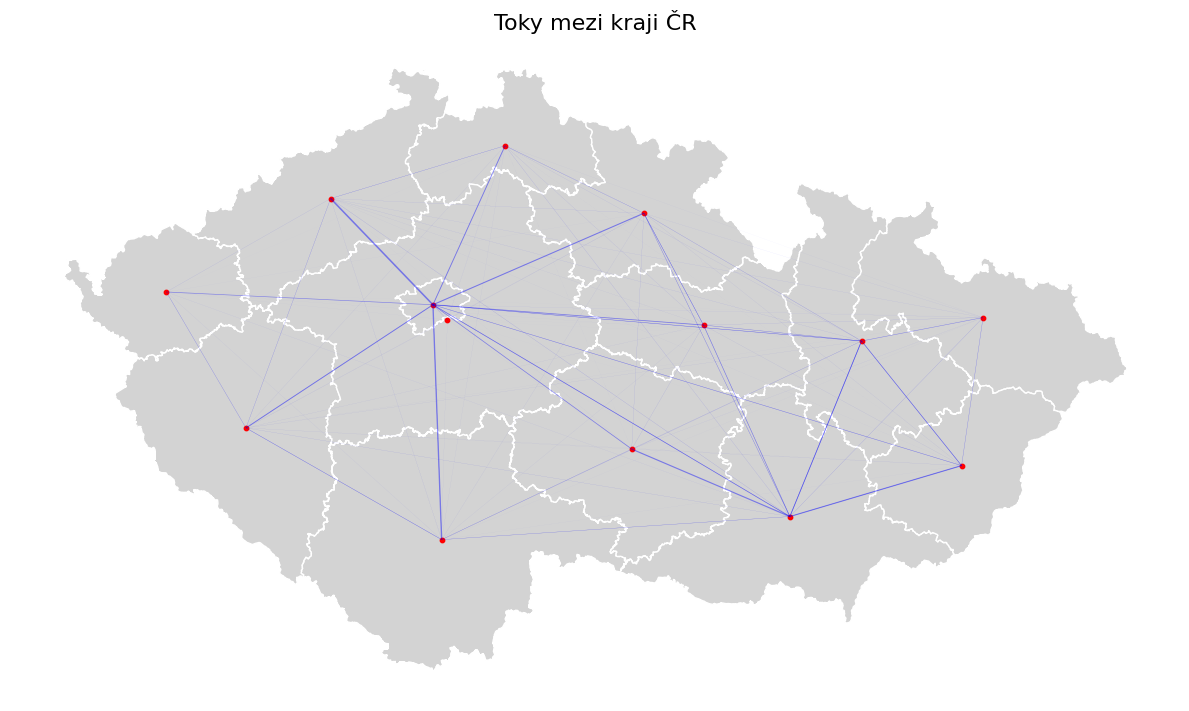

In [7]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString
import matplotlib.pyplot as plt

# Load OD matrix
df = pd.read_excel('../data/czech/data_czech.xlsx')
df = df.rename(columns={'University ↓ / Student →': 'origin'})

# Load spatial regions
gdf = gpd.read_file('../data/czech/regions.gpkg')[['nazev', 'shape_Leng', 'shape_Area', 'geometry']]

# Compute centroids
gdf['centroid'] = gdf.geometry.centroid

# Reshape OD matrix to long format
df_long = df.melt(id_vars='origin', var_name='destination', value_name='value')
df_long['origin'] = df_long['origin'].str.strip()
df_long['destination'] = df_long['destination'].str.strip()

# Merge centroids for origin and destination
df_long = df_long.merge(gdf[['nazev', 'centroid']], left_on='origin', right_on='nazev', how='left') \
                 .rename(columns={'centroid': 'centroid_origin'}).drop(columns='nazev')
df_long = df_long.merge(gdf[['nazev', 'centroid']], left_on='destination', right_on='nazev', how='left') \
                 .rename(columns={'centroid': 'centroid_destination'}).drop(columns='nazev')

# Filter valid rows
df_long = df_long[(df_long['value'] > 0) & df_long['centroid_origin'].notnull() & df_long['centroid_destination'].notnull()]

# Create flow lines
df_long['geometry'] = df_long.apply(lambda row: LineString([row['centroid_origin'], row['centroid_destination']]), axis=1)

# Convert to GeoDataFrame
gdf_flows = gpd.GeoDataFrame(df_long, geometry='geometry', crs=gdf.crs)
gdf_flows['weight'] = gdf_flows['value'] / gdf_flows['value'].max() * 5

# Plot
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
gdf.plot(ax=ax, color='lightgrey', edgecolor='white')
gdf_flows.plot(ax=ax, linewidth=gdf_flows['weight'], color='blue', alpha=0.4)
gdf.set_geometry('centroid').plot(ax=ax, color='red', markersize=10)

ax.set_title("Toky mezi kraji ČR", fontsize=16)
ax.axis('off')
plt.tight_layout()
plt.show()
